In [1]:
import xarray as xr
import xgcm
import numpy as np
from typing import Annotated
from xarray.indexes import PandasIndex

In [2]:
def open_llc4320_velocity_data(chunks='auto', time_range=None):
    
    ds_SSU = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssu", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    ds_SSV = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssv", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    # Open grid data
    ds_grid = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/grid", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    coords_to_keep = ['XC', 'YC', 'dxC', 'dyC', 'dxG', 'dyG', 'rAz', 'rA', 'Depth']
    ds_grid = ds_grid.reset_coords()[coords_to_keep]
    
    ds = xr.merge([ds_SSU, ds_SSV, ds_grid])
    
    if time_range is not None:
        ds = ds.isel(time=time_range)
        
    ds = ds.chunk(chunks)
    
    return ds, ds_grid
    

In [3]:
ds, ds_grid = open_llc4320_velocity_data(chunks={})

In [4]:
grid = xgcm.Grid(ds_grid, periodic=False)

In [5]:
def calc_f_coriolis(ds_grid):
    """Calculate the coriolis frequency for all latitudes"""
    
    lat = ds_grid['YC'].reset_coords(drop=True).rename('lat')
    
    rotation_rate = 7.2921e-5  # rad/s
    f_coriolis = (
        2 * rotation_rate * np.sin(lat*np.pi/180)
    ).rename('f_coriolis')
    
    return f_coriolis

In [6]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def vort(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
    raz: Annotated[np.ndarray, "(Y:left,X:left)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    """Dimensional vorticity"""
    
    u_trans = u * dxc
    v_trans = v * dyc
    v_diff_x = v_trans[..., 1:, 1:] - v_trans[..., 1:, :-1]
    u_diff_y = u_trans[..., 1:, 1:] - u_trans[..., :-1, 1:]
    return (v_diff_x - u_diff_y) / raz[..., 1:, 1:]

In [7]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def strain(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
    v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
    u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_x_trimmed = v_diff_x[..., 1:, :]
    u_diff_y_trimmed = u_diff_y[..., 1:]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    strain_normal = u_diff_x_trimmed - v_diff_y_trimmed
    strain_shear = v_diff_x_trimmed + u_diff_y_trimmed
    
    # TODO: interpolate the shear strain onto the positions of the normal strain
    # For now, we just pretend they are at the same grid point
    strain_mag = np.sqrt(strain_normal ** 2 +  strain_shear ** 2)
    
    return strain_mag

In [8]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",
)
def divergence(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxg: Annotated[np.ndarray, "(Y:left,X:center)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyg: Annotated[np.ndarray, "(Y:center,X:left)"],
    ra:  Annotated[np.ndarray, "(Y:center,X:center)"],
) ->     Annotated[np.ndarray, "(Y:center,X:center)"]:
    
    u_diff_x = (u[..., 1:] - u[..., :-1]) * dxg[..., 1:]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) * dyg[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    divergence = (u_diff_x_trimmed + v_diff_y_trimmed) / ra[..., 1:, 1:]
    
    return divergence

In [9]:
def calc_vort_strain_div(ds, grid):
    """Calculate normalised vorticity, strain and divergence from U and V."""
    
    # vorticity
    ζ = vort(grid, ds.U, ds.dxC, ds.V, ds.dyC, ds.rAz, axis= 5 * [("Y", "X")])
    ζ = ζ.assign_coords({"time": ds.time.values})  # TODO won't need this line once xgcm #575 is fixed
    ζ = ζ.rename({"i_g": "i", "j_g": "j"})  # pretend it's now on cell centers to match other fields
    
    # strain
    σ = strain(grid, ds.U, ds.dxC, ds.V, ds.dyC, axis=4 * [("Y", "X")])
    σ = σ.assign_coords({"time": ds.time.values})
    σ = σ.rename({"i_g": "i", "j_g": "j"})
    
    # divergence
    D = divergence(grid, ds.U, ds.dxG, ds.V, ds.dyG, ds.rA, axis= 5 * [("Y", "X")])# / abs(f_coriolis)
    D = D.assign_coords({"time": ds.time.values})
    D = D.rename("div")
    
    # Normalise
    # TODO: Would be neater to normalise inside grid ufunc but then we would also pad f unneccessarily     
    f_coriolis = calc_f_coriolis(ds_grid)
    ζ = ζ / f_coriolis
    σ = σ / abs(f_coriolis)
    D = D / abs(f_coriolis)
    
    # merge everything
    results = xr.merge(
        [
            ζ.rename("vort"),
            σ.rename("strain"),
            D.rename("div"),
            f_coriolis,
            ds_grid[['XC', 'YC', 'rA', 'Depth']]
        ]
    ).set_coords(['XC', 'YC', 'rA', 'Depth'])
    
    return results

In [10]:
results = calc_vort_strain_div(ds, grid)

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [11]:
def split_into_regions(results):#, vertices_longitude, vertices_latitude):
    
    regions = results.coarsen(
        i=540,
        j=540,
    ).construct(
        i=("i_region_coarse", "i_region"),
        j=("j_region_coarse", "j_region"),
    ).stack(region=['face', 'i_region_coarse', 'j_region_coarse'])
    
    #regions = regions.assign_coords(vertices_longitude=vertices_longitude, vertices_latitude=vertices_latitude)
    
    # keep a unique number for each region, and give it an index
    regions = regions.assign_coords(region_num=('region', np.arange(len(regions.region))))
    #regions = regions.set_xindex('region_num', PandasIndex)
    
    return regions

In [12]:
regions = split_into_regions(results)

In [13]:
regions

<xarray.Dataset> Size: 26TB
Dimensions:          (i_region: 540, region: 832, j_region: 540, time: 9030)
Coordinates:
    i                (i_region, region) int64 4MB 0 0 0 0 ... 4319 4319 4319
    j                (j_region, region) int64 4MB 0 540 1080 ... 3239 3779 4319
  * time             (time) datetime64[ns] 72kB 2011-09-13 ... 2012-09-23T05:...
    XC               (j_region, i_region, region) float32 970MB dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    YC               (j_region, i_region, region) float32 970MB dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    rA               (j_region, i_region, region) float32 970MB dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    Depth            (j_region, i_region, region) float32 970MB dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
  * region           (region) object 7kB MultiIndex
  * face             (region) int64 7kB 0 0 0 0 0 0 0 0 ... 12 12 12 12 12 12 12
  * i_region_coarse  (region) int64 7kB 0 0 0 0 0 0 0 0 1 ... 6 7 7 7 7 7 7 7 7
  * j_region_coarse  (region) int64 7kB 0 1 2 3 4 5 6 7 0 ... 7 0 1 2 3 4 5 6 7
    region_num       (region) int64 7kB 0 1 2 3 4 5 ... 826 827 828 829 830 831
Dimensions without coordinates: i_region, j_region
Data variables:
    vort             (time, j_region, i_region, region) float32 9TB dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    strain           (time, j_region, i_region, region) float32 9TB dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    div              (time, j_region, i_region, region) float32 9TB dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    f_coriolis       (j_region, i_region, region) float32 970MB dask.array<chunksize=(540, 540, 64), meta=np.ndarray>

In [14]:
regions = regions.set_xindex('region_num', PandasIndex)

In [58]:
regions.YC.isel(region=20).mean().values

array(-73.94962, dtype=float32)

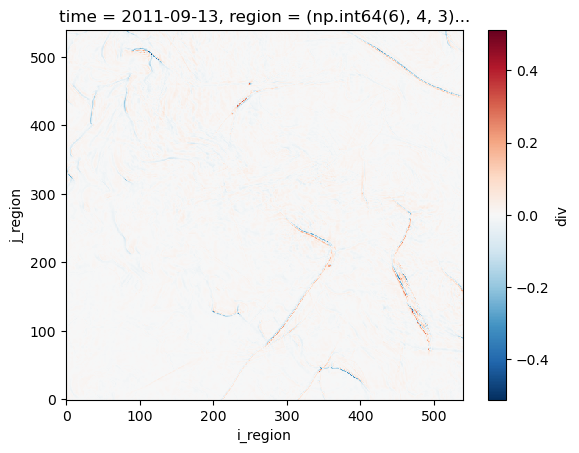

In [62]:
regions.div.isel(region=419).isel(time=0).plot()

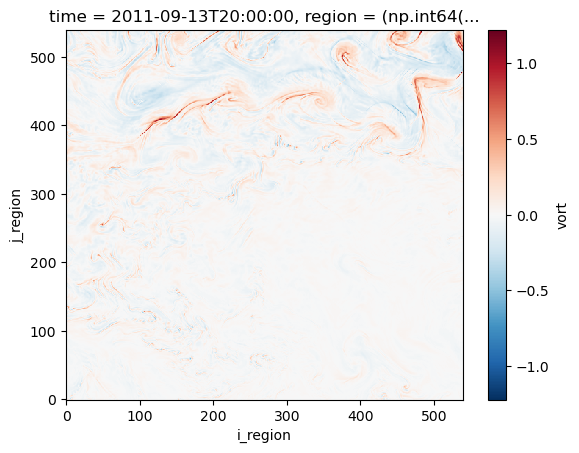

In [76]:
regions.vort.isel(region=23).isel(time=20).plot()

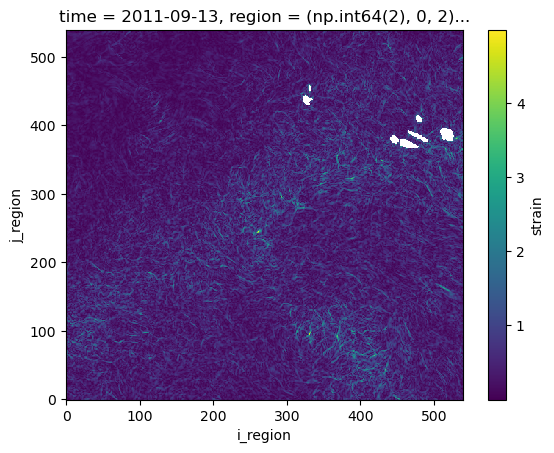

In [69]:
regions.strain.isel(region=130).isel(time=0).plot()

In [31]:
region_name = "ACC"
region_slice = {'region_num': [289, 288, 297, 296]}
local_fields = regions#.sel(**region_slice)
local_fields.YC.mean(['i_region','j_region']).values

array([-88.36888  , -85.57034  , -82.35177  , -78.41796  , -73.95256  ,
       -69.43328  , -64.92012  , -59.900013 , -88.59707  , -85.685585 ,
       -82.40578  , -78.45355  , -73.96616  , -69.43425  , -64.92012  ,
       -59.900013 , -87.41395  , -85.18261  , -82.08035  , -78.260185 ,
       -73.89644  , -69.42892  , -64.92012  , -59.900013 , -86.11564  ,
       -84.492035 , -81.461914 , -77.83664  , -73.781784 , -69.41865  ,
       -64.92012  , -59.900013 , -84.47395  , -83.192825 , -80.87556  ,
       -77.462074 , -73.59036  , -69.40259  , -64.92012  , -59.900013 ,
       -83.13357  , -82.1758   , -79.90508  , -76.97794  , -73.326614 ,
       -69.38204  , -64.92012  , -59.900013 , -81.88491  , -80.819824 ,
       -78.99335  , -76.34412  , -73.05239  , -69.36016  , -64.92012  ,
       -59.900013 , -80.58961  , -80.09483  , -78.38051  , -75.6452   ,
       -72.84532  , -69.34273  , -64.92012  , -59.900013 , -53.91883  ,
       -47.173157 , -39.60268  , -31.136787 , -21.914284 , -12.0

In [43]:
vort_var

<xarray.DataArray 'vort' (time: 37, region: 832)> Size: 123kB
dask.array<getitem, shape=(37, 832), dtype=float32, chunksize=(1, 64), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) datetime64[ns] 296B 2011-09-13 ... 2012-09-22
  * region           (region) object 7kB MultiIndex
  * face             (region) int64 7kB 0 0 0 0 0 0 0 0 ... 12 12 12 12 12 12 12
  * i_region_coarse  (region) int64 7kB 0 0 0 0 0 0 0 0 1 ... 6 7 7 7 7 7 7 7 7
  * j_region_coarse  (region) int64 7kB 0 1 2 3 4 5 6 7 0 ... 7 0 1 2 3 4 5 6 7
  * region_num       (region) int64 7kB 0 1 2 3 4 5 ... 826 827 828 829 830 831

In [23]:
vort_var = (local_fields['vort']).var(['i_region','j_region']).isel(time=slice(0,9030,250))#.plot()
#(local_fields['strain'].isel(region=0)).var(['i_region','j_region']).isel(time=slice(0,9030,500))#.plot()
div_var = (local_fields['div']).var(['i_region','j_region']).isel(time=slice(0,9030,250))#.plot()

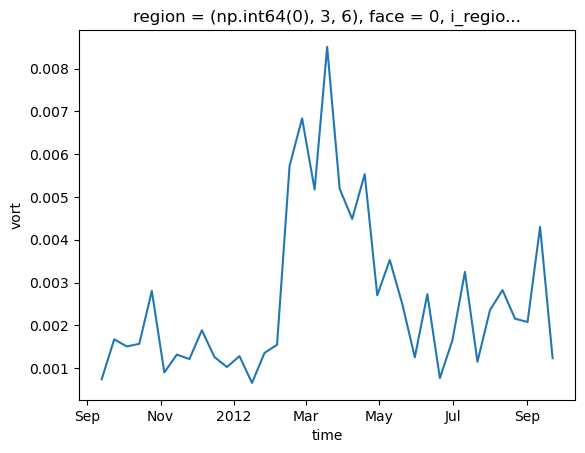

In [34]:
vort_var.isel(region=30).plot()

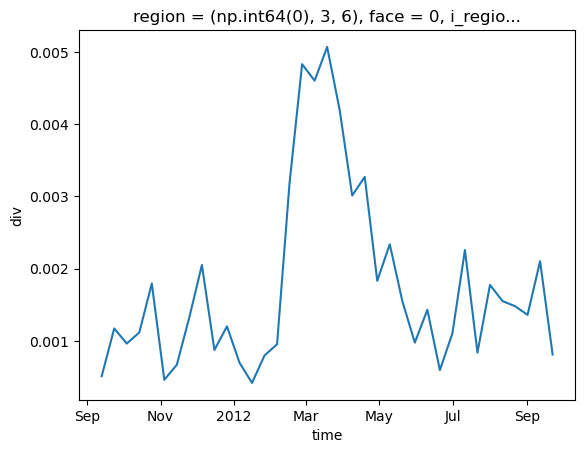

In [35]:
div_var.isel(region=30).plot()

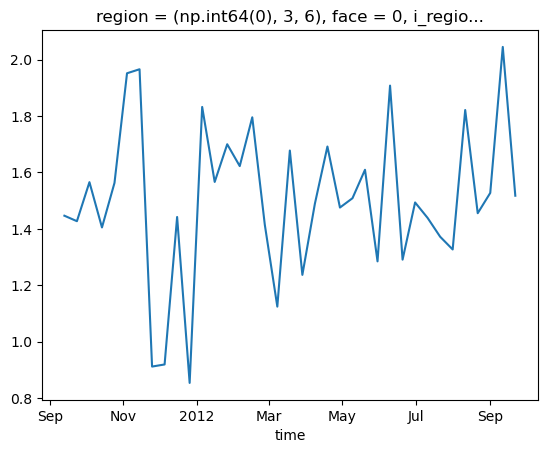

In [37]:
(vort_var.isel(region=30)/div_var.isel(region=30)).plot()

In [83]:
(vort_var/div_var).isel(region=2).plot()

ValueError: cannot re-index or align objects with conflicting indexes found for the following dimensions: 'region' (2 conflicting indexes)
Conflicting indexes may occur when
- they relate to different sets of coordinate and/or dimension names
- they don't have the same type
- they may be used to reindex data along common dimensions